In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib_inline.backend_inline import set_matplotlib_formats
from scipy.stats import ttest_ind, ttest_ind_from_stats
from statsmodels.stats.power import TTestIndPower

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats("svg")

set_matplotlib_formats("svg")

%matplotlib inline

In [61]:
# no effect -> low power
TTestIndPower().power(
    effect_size=0,
    nobs1=1_000_000,
    alpha=0.05,
    ratio=0.5,
)

0.049999999999999885

In [8]:
def generate_experiment(size: int, p_a: float, p_b: float) -> dict:
    sample_a = np.random.binomial(n=1, p=p_a, size=size)
    sample_b = np.random.binomial(n=1, p=p_b, size=size)

    stat, p_val = ttest_ind(sample_a, sample_b, equal_var=False)

    with np.errstate(divide="ignore", invalid="ignore"):

        mean_a, mean_b = sample_a.mean(), sample_b.mean()
        rel_effect_size = (mean_b - mean_a) / np.abs(mean_a)

        return {
            "mean_a": mean_a,
            "mean_b": mean_b,
            "std_a": sample_a.std(),
            "std_b": sample_b.std(),
            "rel_effect_size": rel_effect_size,
            "stat": stat,
            "p_val": p_val,
        }

In [11]:
def simulate_two_sizes(
    size_1: int,
    size_2: int,
    p_a: float,
    p_b: float,
    repeats: int = 1000,
) -> pd.DataFrame:
    def generate_experiments(size: int) -> pd.DataFrame:
        experiments = pd.DataFrame(
            generate_experiment(size, p_a, p_b) for _ in range(repeats)
        )
        experiments["size"] = size
        experiments["effect_exists"] = p_a != p_b
        return experiments

    return pd.concat(
        objs=[
            generate_experiments(size_1),
            generate_experiments(size_2),
        ],
        ignore_index=True,
    )

In [14]:
small = 100
large = 50_000

results_effect_exists = simulate_two_sizes(
    size_1=small,
    size_2=large,
    p_a=0.03,
    p_b=0.032,
)

results_no_effect = simulate_two_sizes(
    size_1=small,
    size_2=large,
    p_a=0.03,
    p_b=0.03,
)


results = pd.concat(objs=[results_effect_exists, results_no_effect], ignore_index=True)

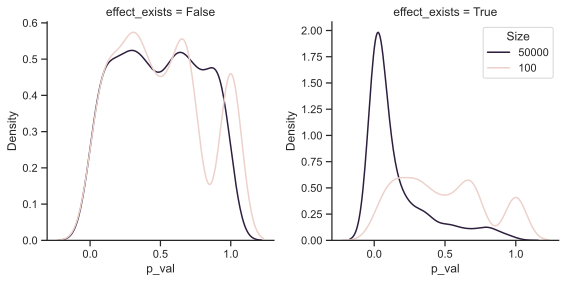

In [71]:
# low power -> noisy p.value
# no effect -> always low power
g = sns.FacetGrid(results, col="effect_exists", sharey=False, sharex=False, height=4)
g.map_dataframe(sns.kdeplot, x="p_val", hue="size", legend=True)
plt.legend(title="Size", loc="upper right", labels=[large, small])
plt.show()

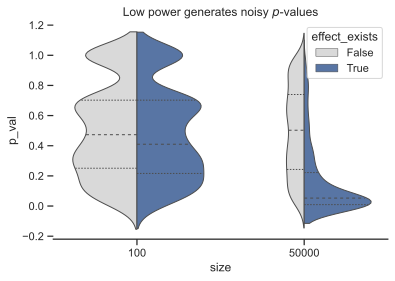

In [69]:
sns.violinplot(
    data=results,
    x="size",
    y="p_val",
    hue="effect_exists",
    split=True,
    inner="quart",
    linewidth=1,
    palette={True: "b", False: ".85"},
)
sns.despine(left=True)
plt.title("Low power generates noisy $p$-values")
plt.show()